Assignment 4: Anomaly Detection Using Autoencoder 🕵️
Implement anomaly detection using an autoencoder.

a. Import required libraries. 📚
b. Upload/access the dataset. 📂
c. Encoder converts data into a latent representation. 🧐
d. Decoder networks convert it back to the original input. 🔄
e. Compile the models with Optimizer, Loss, and Evaluation Metrics. 📈

In [1]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32")/255.0
x_test  = x_test.astype("float32")/255.0
x_train = x_train.reshape((-1, 28*28))
x_test  = x_test.reshape((-1, 28*28))


In [3]:
normal_class = 0
x_train_norm = x_train[y_train == normal_class]           

In [4]:
val_frac = 0.1
n_val = int(len(x_train_norm)*val_frac)
x_val_norm = x_train_norm[:n_val]
x_tr_norm  = x_train_norm[n_val:]

In [5]:
y_test_anom = (y_test != normal_class).astype(int)

In [6]:
inp = layers.Input(shape=(28*28,))
e = layers.Dense(256, activation="relu")(inp)
e = layers.Dense(64, activation="relu")(e)
z = layers.Dense(16, activation="relu", name="latent")(e)

In [7]:
d = layers.Dense(64, activation="relu")(z)
d = layers.Dense(256, activation="relu")(d)
out = layers.Dense(28*28, activation="sigmoid")(d)

autoencoder = Model(inp, out, name="mnist_autoencoder")

In [8]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss="mse",
                    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])

In [9]:
hist = autoencoder.fit(x_tr_norm, x_tr_norm,
                       validation_data=(x_val_norm, x_val_norm),
                       epochs=20, batch_size=256, verbose=1)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1366 - mae: 0.2939 - val_loss: 0.0696 - val_mae: 0.1327
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0674 - mae: 0.1335 - val_loss: 0.0626 - val_mae: 0.1310
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0614 - mae: 0.1310 - val_loss: 0.0531 - val_mae: 0.1194
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0509 - mae: 0.1126 - val_loss: 0.0436 - val_mae: 0.1016
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0431 - mae: 0.0988 - val_loss: 0.0390 - val_mae: 0.0920
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0394 - mae: 0.0930 - val_loss: 0.0363 - val_mae: 0.0882
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0363 - mae: 0.0884 - val_loss: 0.0333 - val_mae: 0.0834
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0333 - mae: 0.0829 - val_loss: 0.0312 - val_mae: 0.0791
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.031

In [10]:
val_rec = autoencoder.predict(x_val_norm, verbose=0)
val_err = np.mean(np.square(x_val_norm - val_rec), axis=1)
threshold = np.percentile(val_err, 99)                        
print(f"Chosen anomaly threshold (val 99th pct): {threshold:.6f}")

Chosen anomaly threshold (val 99th pct): 0.048687


In [11]:
test_rec = autoencoder.predict(x_test, verbose=0)
test_err = np.mean(np.square(x_test - test_rec), axis=1)
y_pred = (test_err > threshold).astype(int)

In [12]:
auc_roc = roc_auc_score(y_test_anom, test_err)                  # higher error ⇒ more anomalous
auc_pr  = average_precision_score(y_test_anom, test_err)
acc = accuracy_score(y_test_anom, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_anom, y_pred, average="binary")

print(f"AUC-ROC: {auc_roc:.4f} | AP: {auc_pr:.4f}")
print(f"Acc: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

AUC-ROC: 0.9931 | AP: 0.9992
Acc: 0.8992 | Precision: 0.9981 | Recall: 0.8899 | F1: 0.9409


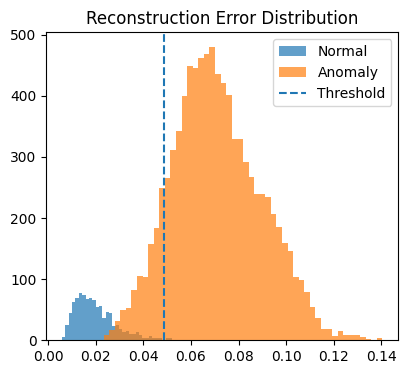

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(test_err[y_test_anom==0], bins=50, alpha=0.7, label="Normal")
plt.hist(test_err[y_test_anom==1], bins=50, alpha=0.7, label="Anomaly")
plt.axvline(threshold, linestyle="--", label="Threshold")
plt.title("Reconstruction Error Distribution")
plt.legend()

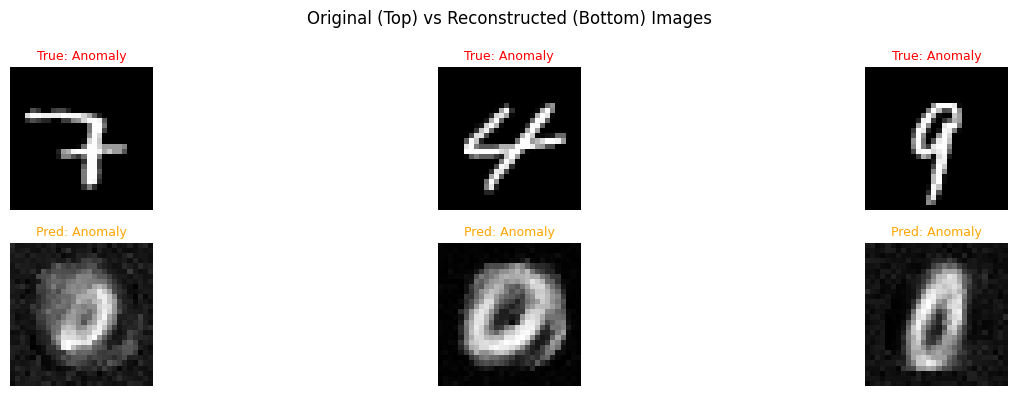

In [14]:
import random
num_images = 3
random_indices = np.random.choice(len(x_test), num_images, replace=False)
plt.figure(figsize=(15, 4))
for i, idx in enumerate(random_indices):
    orig = x_test[idx].reshape(28, 28)
    recon = test_rec[idx].reshape(28, 28)
    err = test_err[idx]
    pred_label = "Anomaly" if y_pred[idx] == 1 else "Normal"
    true_label = "Anomaly" if y_test_anom[idx] == 1 else "Normal"

    plt.subplot(2, num_images, i + 1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"True: {true_label}", fontsize=9, color='green' if true_label=="Normal" else 'red')
    plt.axis('off')

    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(recon, cmap='gray')
    plt.title(f"Pred: {pred_label}", fontsize=9, color='blue' if pred_label=="Normal" else 'orange')
    plt.axis('off')

plt.suptitle("Original (Top) vs Reconstructed (Bottom) Images", fontsize=12)
plt.tight_layout()
plt.show()